In [4]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from pydataset import data

144


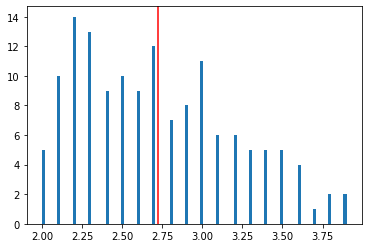

In [5]:
nums_orig = data('cats').Bwt  #body weight of a bunch of cats
print(len(nums_orig))

plt.hist(nums_orig,bins=100)
plt.axvline(x=nums_orig.mean(), color='r')
plt.show()



In [6]:
N=100

def sample_mean_std(buf, N):
    samp = np.random.choice(buf, size=N)
    mean = samp.mean()
    mean_diff = samp-mean
    s = (np.sum(np.power(mean_diff, 2)) / N)
    std_dev_est = math.sqrt(s)/math.sqrt(N)
    return (mean, std_dev_est)

(u,std) = sample_mean_std(nums_orig, N)
true_u=nums_orig.mean()
print("true mean=%.2f, est. mean=%.2f, 95%%ci = (%.2f, %.2f)"%(true_u, u, u-2*std, u+2*std))

true mean=2.72, est. mean=2.65, 95%ci = (2.55, 2.75)


hit 95.18% of samples


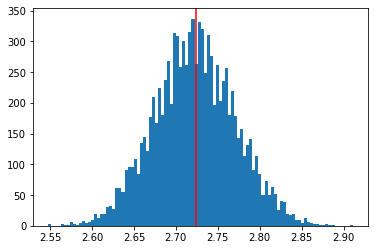

In [7]:
hit = 0
means = []
for i in range(0,10000):
    (u,std) = sample_mean_std(nums_orig, N)
    err = np.abs(u - true_u)
    success = err < 2 * std
    if (success):
        hit = hit + 1
    means.append(u)

print("hit %.2f%% of samples"%(hit/10000.0 * 100))
plt.hist(means,bins=100)
plt.axvline(x=nums_orig.mean(), color='r')



true median=2.70
bootstrap median=2.50, 2.70


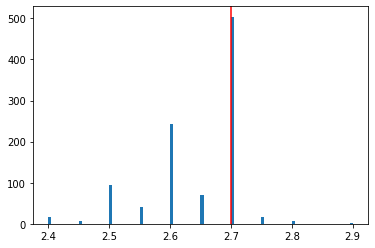

true mean=2.72
bootstrap mean=2.60, 2.75


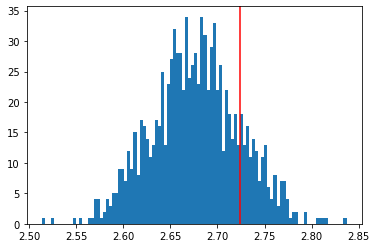

In [11]:
N_boots = 1000
N = 100

def bootstrap(buf, fn, n_boots,ci,samp_size=N):
    vals = []
    buf_s = np.random.choice(buf,size=samp_size)
    for i in range(0,n_boots):
        samp = np.random.choice(buf_s, size=samp_size, replace=True)
        vals.append(fn(samp))
    return(np.percentile(vals,ci), np.percentile(vals,100.0-ci), vals)


print("true median=%.2f"%(np.median(nums_orig)))
(ci1, ci2, vals) = bootstrap(nums_orig,np.median,N_boots,5.0)
print("bootstrap median=%.2f, %.2f"%(ci1, ci2))
plt.hist(vals,bins=100)
plt.axvline(x=nums_orig.median(), color='r')
plt.show()


print("true mean=%.2f"%(true_u))
(ci1, ci2, vals) = bootstrap(nums_orig,np.mean,N_boots,5.0)
print("bootstrap mean=%.2f, %.2f"%(ci1, ci2))
plt.hist(vals,bins=100)
plt.axvline(x=nums_orig.mean(), color='r')
plt.show()



In [65]:
import hyperloglog
from faker import Faker

error_rate = 0.05
hll = hyperloglog.HyperLogLog(error_rate)  
p = int(math.ceil(math.log((1.04 / error_rate) ** 2, 2)))
print("%d buckets needed"%(1 << p))

fake = Faker()
ns = []
for i in range(0,100):
    ns.append(fake.name().encode('utf-8'))

samps = np.random.choice(ns, size=10000, replace=True)
for s in samps:
    hll.add(s)
print(len(hll))

512 buckets needed
97


In [60]:
import hashlib
def count_lead_zeroes(d,b):
    # https://graphics.stanford.edu/~seander/bithacks.html#ZerosOnRightLinear
    #print bin(d)
    if d:
        leading = b
        v = d
        while v:
            v >>= 1
            leading -= 1
        #print bin(d)
        #print leading
        return leading + 1
    return b

nbits = 64

def int_hash(s):
    h = hashlib.sha1(s)
    return h.hexdigest()[:nbits//4]

def get_first(s,i):
    part = s[0:i//4]
    return int(part,16)

def get_last(s,i):
    offset = i//4
    part = s[offset:]
    return int(part,16)



In [66]:
bucket_bits = 8
buckets = int(math.pow(2, bucket_bits))
print(buckets)

hashes = []
for name in ns:
    h = int_hash(name)
    hashes.append(h)

samps = np.random.choice(hashes, size=10000, replace=True)


256


In [67]:

def get_alpha(p):
    if not (4 <= p <= 16):
        raise ValueError("p=%d should be in range [4 : 16]" % p)

    if p == 4:
        return 0.673

    if p == 5:
        return 0.697

    if p == 6:
        return 0.709

    return 0.7213 / (1.0 + 1.079 / (1 << p))


In [71]:
mx = np.zeros(buckets)

for s in samps:
    i = get_first(s,bucket_bits)
    j = get_last(s,bucket_bits)
    
    nzeros = count_lead_zeroes(j, nbits - bucket_bits)
    if (nzeros > mx[i]):
        mx[i] = nzeros
sum = 0

#compute the harmonic mean of the registers
for i in range(0,buckets):
    exp = math.pow(2.0, -mx[i])
    sum = sum + exp
sum = 1/sum

E = sum * buckets**2 * get_alpha(bucket_bits)

zeros = len(mx) - np.count_nonzero(mx) 
if (zeros > 0 and E < 2.5 * buckets):
    H = buckets * math.log(buckets / float(zeros))
    print(int(round(H)))
else:
    print(int(round(E)))




100
